# Group Assignment 5 | Group 13
Sam Goodyear, Kimmy Rice, Bonita Wankhade
## Difference-in-means and regression: Existing tree canopy coverage in relation to median household income in Boyle Heights and Echo Park
To see whether tree canopy coverage is equitably distrubuted across the LA region, we are statistically analyzing two neighborhoods through a difference-in-means test and regression analysis.

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

sns.set_style("whitegrid")
sns.set_context("paper")

In [2]:
# load tree canopy cover dataset and clean

df_trees = pd.read_csv('https://raw.githubusercontent.com/bonitaw04/project-files/refs/heads/main/existing_tree_cover.csv')
df_trees['geoid'] = df_trees['geoid'].astype(str).str[-6:] # make geoid a string for analysis and slice
df_trees.head() # preview data

,geoid,geoid20,year,denom_totalarea,existing_canopy_count,existing_canopy_pct,possible_canopy_count,possible_canopy_pct
0,101110,101110,2016,12298162.00,2.827224e+06,22.988993,5.520896e+06,44.892036
1,101122,101122,2016,28511170.00,7.808231e+06,27.386568,1.620918e+07,56.852043
2,101220,101220,2016,7528351.50,2.091405e+06,27.780382,2.932750e+06,38.956078
3,101221,101221,2016,3798988.00,6.090615e+05,16.032204,1.648872e+06,43.402924
4,101222,101222,2016,3180596.75,5.099198e+05,16.032206,1.380472e+06,43.402924


In [3]:
# same process with median household income data

df_income = pd.read_csv('https://raw.githubusercontent.com/bonitaw04/project-files/refs/heads/main/Median%20Household%20Income%20-%202023.csv')
df_income['geoid'] = df_income['geoid'].astype(str).str[-6:]
df_income.head()

,geoid,geoid20,year,denom_total_hh,med_hh_inc_adj,med_hh_inc
0,101110,101110,2023,1679.0,84091.0,84091.0
1,101122,101122,2023,1452.0,99583.0,99583.0
2,101220,101220,2023,1380.0,69676.0,69676.0
3,101221,101221,2023,1569.0,53798.0,53798.0
4,101222,101222,2023,1036.0,45662.0,45662.0


In [4]:
# merge tree canopy cover + median household income data by geoid

trees_income = pd.merge(
    left=df_trees, right=df_income, how="left", left_on="geoid", right_on="geoid"
)

In [5]:
# identify tracts making up boyle heights and echo park neighborhoods, respectively

boyle_tracts = ['203100', '203200', '203300', '203601', '203602', '203710', '203720', '203800', '203900', '204110', '204120', '204200', '204300', '204410', '204420', '204600', '204700', '204810', '204820', '204910', '204920', '205110', '205120', '206050', '206053', '206054']
echo_tracts = ['195600', '195720', '197300', '197410', '197420', '197500', '197600', '197700', '208002']

In [6]:
# create groups based on tracts and drop null values

var = 'existing_canopy_pct'
group1 = trees_income[trees_income['geoid'].isin(boyle_tracts)][var].dropna()
group2 = trees_income[trees_income['geoid'].isin(echo_tracts)][var].dropna()

# Difference-in-means test

In [7]:
# calculate mean of each neighborhood's existing percent of tree canopy cover

print(int(group1.mean()))
print(int(group2.mean()))

# the results show that boyle heights' tracts have an average of 12% tree canopy
# while echo park has an average of 21%

12
21


In [8]:
# find the difference in means

group2.mean() - group1.mean()

np.float64(9.520550547863246)

In [9]:
# two-sample t-test comparing tree canopy percentages between the two neighborhoods

t_statistic, p_value = stats.ttest_ind(group1, group2, equal_var=False, nan_policy="omit")
p_value = p_value / 2
print(t_statistic)
print(p_value)

-3.5703559501825155
0.002901171889395288


In [10]:
alpha = 0.05
p_value < alpha

np.True_

Because our found p-value of 0.0029 is less than our alpha value of 0.05, we can reject the null hypothesis (that there is no significant difference in mean tree canopy coverage between Boyle Heights and Echo Park), as it is unlikely to have occurred by chance.

The p-value tells us that the difference is statistically significant, but we can infer that this difference is a result of the neighborhoods' individual histories. Boyle Heights' tree canopy coverage is likely lower because of its history as an immigrant community rife with disinvestment. Echo Park, while having a similar history, has been undergoing gentrification and urban greening over the past few decades.

# Regression Analysis
Null hypothesis: There is no relationship between median household income and tree canopy cover in Los Angeles.

In [11]:
# identify our response/dependent and predictor/independent variables:
# median household income and existing tree canopy coverage, respectively
# since we are investigating whether wealthier neighborhoods have more tree canopy coverage

response = "med_hh_inc"
predictor = "existing_canopy_pct"

In [12]:
# drop null values

data = trees_income[[response, predictor]].dropna()
print(data.shape)

(2451, 2)


In [13]:
X = data[predictor]
y = data[response]

In [14]:
model = sm.OLS(y, sm.add_constant(X))
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             med_hh_inc   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     1083.
Date:                Mon, 24 Nov 2025   Prob (F-statistic):          4.78e-197
Time:                        06:10:25   Log-Likelihood:                -29008.
No. Observations:                2451   AIC:                         5.802e+04
Df Residuals:                    2449   BIC:                         5.803e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                4.794e+04   1

## Interpretation

**Coefficient:** For one percentage point increase in tree canopy coverage, median household income increases by about $2,602.

The results are statistically significant, given the p-value/t-statistic:

p-value = 0.000
t-statistic = 32.9

We can confidently **reject** the null hypothesis.

**R^2 value:** Given the R-squared value, we can conclude that ~31% of the variance in median household income is caused by tree canopy coverage.

**Intercept:** A tract with 0% tree coverage would have a median household income of about $47,940.

Given these statistics, we can say that neighborhoods with more trees, and therefore shade, tend to have higher median household incomes. The model suggests that the two are highly related, which matches the anecdotal, real-world experience of disadvantaged communities who struggle with access to clean air, green spaces, and cooling facilities; and, conversely, wealthier communities with an abundance of parks and open space.

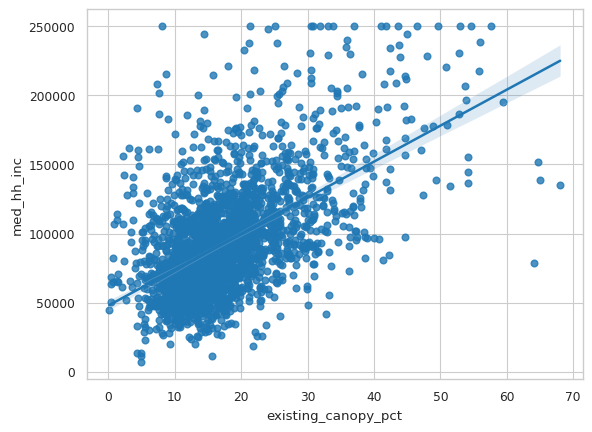

In [15]:
ax = sns.regplot(x=X, y=y)

In [20]:
# changing the titles of X and Y axis
ax.set_xlabel("Tree Canopy Coverage")
ax.set_ylabel("Median Household Income")
ax.get_figure().savefig("regression_analysis_group_13_project_5.png")

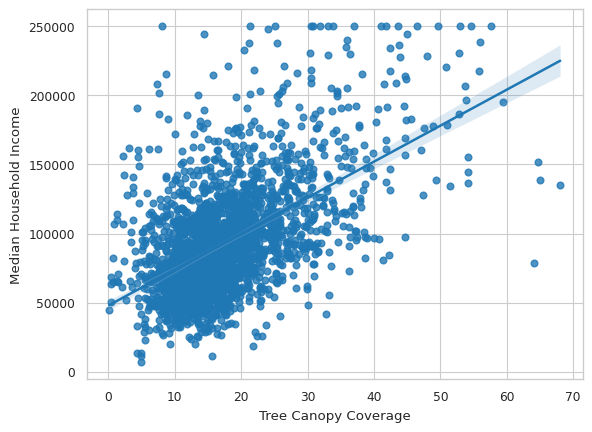

In [19]:
ax.get_figure()

Project Breakdown:
Initial Code: Bonita;
Analysis, Markdowns, & Revisions: Kimmy & Sam
